# Training a 9 Layer Neural network to predict suicidal intent

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

import string
import re

import preprocess_text as pt


from pandarallel import pandarallel
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

#### Invoking garbage collection

In [1]:
import gc

gc.collect()

385

#### Loading the data using the preprocess_text script
1. We did not perform standardization on the dataset, as we are implementing it as a part of our TensorFlow Pipeline 

In [3]:
train_df,val_df = pt.suicidal_intent_data_load(test_dataset=False,standardization=False)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
# Initializing Pandarallel for parallel application of functions.
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


2. Using the NLTK Stemmer to perform stemming on the dataset

In [5]:
def stemmer_parallel(input):
    import nltk
    stemmer = nltk.SnowballStemmer("english")
    return ' '.join([stemmer.stem(word) for word in input.split(' ')])

In [6]:
train_df["text"] = train_df["text"].parallel_apply(stemmer_parallel)
val_df["text"] = val_df["text"].parallel_apply(stemmer_parallel)

4. Lets find the average Sequence length of a word in the dataset.

In [7]:
SQ_LEN = train_df["text"].apply(lambda x: len(x.split()))

In [8]:
val_SQ_LEN = val_df["text"].apply(lambda x: len(x.split()))

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1600x1000 with 0 Axes>

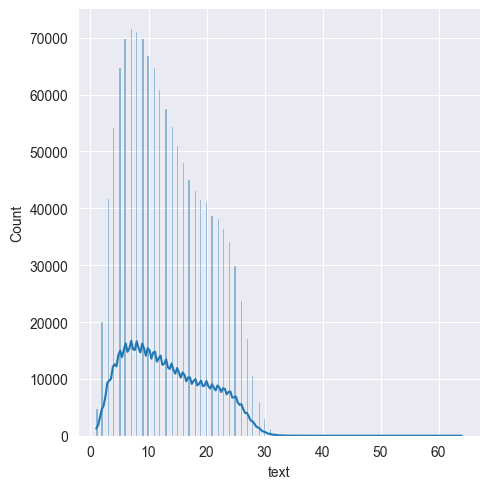

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,10))
sns.displot(SQ_LEN, kde=True)

<Figure size 1600x1000 with 0 Axes>

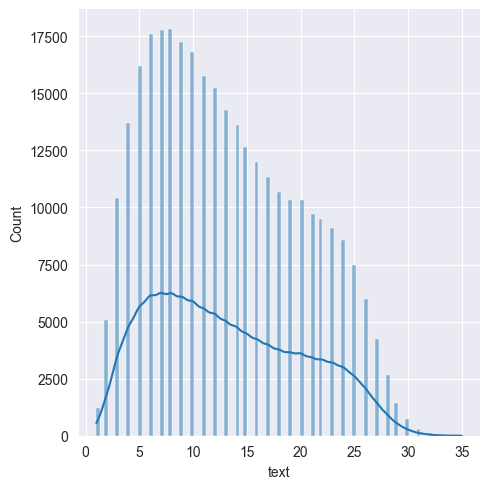

In [11]:
plt.figure(figsize=(16,10))
sns.displot(val_SQ_LEN, kde=True)

In [22]:
max_length = SQ_LEN.max()
max_length

64

As we can see, the average sequence length in the dataset is around 20-30 words, while the max is around 60

5. Let us now create a tf.data.Dataset using the dataset for batch processing in tensorflow

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe["text"].values, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [14]:
raw_train_ds = df_to_dataset(train_df)
raw_val_ds = df_to_dataset(val_df)


print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")


Number of batches in raw_train_ds: 40000
Number of batches in raw_val_ds: 10000


In [15]:
for feature_batch,label_batch in raw_train_ds.take(1):
    print("feature:",feature_batch) 
    print("label:",label_batch)

feature: tf.Tensor(
[b'@simonelechat i love snoozi '
 b'bgp ist soooooooooooooo toooooooooollllllll '
 b'@reycz oooh you better tell me if it was good sux that i couldnt go '
 b'is at hurrican harbor all day for the cardboard boat regatta! '
 b'@mr_geoff polit and drama exam '
 b'@oliviaftw http://twitpic.com/7hc7v - charlieeeeeee! he sooooo cute! i miss coco! '
 b'hmmm, is bore .. i expect that my friend is link here '
 b'@jonasbroth http://twitpic.com/7ev20 - wow, amaz ! '
 b'phone team! just went to coldston with one of the girls. love the bond '
 b"blah, blah, blah... i'm sure it all for a good cause, but let me help by buy more heinekens! hahaha  http://twitpic.com/3n88p"
 b'@evanishect coolio, also got killers, script + others. it feel like age sinc we lili for me now, cant believ it was a week ago! '
 b'@sarah000kraft  hook me up with your tunes... '
 b"don't know about you, but www.tumblr.com has excel visual for blogging, but not much flexibl though "
 b"@joeymcintyr we can't 

6. Let us now define the preprocessing steps to be taken on the data.
    1. We need to convert the words to lowercase
    2. We should remove all occurences of 
        1. Hashtag
        2. Mentions
        3. Emojis
        4. Emoticons
        5. URL's
        6. Numbers

In [16]:
class Patterns:
    URL_PATTERN_STR = r"^((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*$"
    HASHTAG_STR = r'#\w*'
    MENTION_STR = r'@\w*'
    EMOJIS_STR = u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])'
    SMILEYS_STR = r"(\s?:X|:|;|=)(?:-)?(?:\)+|\(|O|D|P|S|\\|\/\s){1,}"
    NUMBERS_STR = r"(^|\s)(-?\d+([.,]?\d+)*)"
    PUNCTUATION_STR = r"[^\w\s]"

def custom_standardizer(input):
    lowercase = tf.strings.lower(input)
    processed = tf.strings.regex_replace(lowercase, Patterns.URL_PATTERN_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.HASHTAG_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.MENTION_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.EMOJIS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.SMILEYS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.NUMBERS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.PUNCTUATION_STR, "")
    return processed

7. let us now define the vectorize layer that will vectorize our words, and also perform the standadization on them.

In [23]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = int(max_length)

vectorize_layer = TextVectorization(
    standardize=custom_standardizer,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [24]:
text_ds = raw_train_ds.map(lambda x, y: x) # Retrieve all text values from the dataset

In [25]:
vectorize_layer.adapt(text_ds) # Adapt the vectorize layer to generate vector embeddings

8. We now vectorize all the strings on the dataset, after adapting the vectorizer

In [26]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)


# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)


In [27]:
for feature_batch,label_batch in train_ds.take(1):
    print("feature:",feature_batch) 
    print("label:",label_batch)

feature: tf.Tensor(
[[  141     9  5515 ...     0     0     0]
 [ 1332  1510    10 ...     0     0     0]
 [    1     1    55 ...     0     0     0]
 ...
 [   23   210     3 ...     0     0     0]
 [ 1605   115   525 ...     0     0     0]
 [16444     4   778 ...     0     0     0]], shape=(32, 64), dtype=int64)
label: tf.Tensor([1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1], shape=(32,), dtype=int32)


9. Let us save the data as a precaution.

In [28]:
train_ds.save("model_checkpoints/neural_net/train_data")
val_ds.save("model_checkpoints/neural_net/val_data")

In [29]:
# Delete all unneeded variables and free up memory
del raw_train_ds,raw_val_ds,train_df,val_df,train_ds,val_ds,text_ds
gc.collect()

2793

In [30]:
train_ds = tf.data.Dataset.load("model_checkpoints/neural_net/train_data")
val_ds = tf.data.Dataset.load("model_checkpoints/neural_net/val_data")

10. Let us now define the model.
    1. We are using the embedding layer as this is for turning positive integers (indexes) into dense vectors of fixed size.
    2. A 0.5 dropout layer
    3. 2 Conv1D layers with a relu activation layer.
    4. A Global Max Pooling layer
    5. A dense layer
    6. A dropout layer
    7. A dense layer
11. We then setup the model with a adam optimizer and a binary_crossentropy loss function.

In [31]:
max_features = 20000
embedding_dim = 128
sequence_length = 500
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"],run_eagerly=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_outputs/neural_net/best_model",save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

12. We then fit the datasets on the model.

In [33]:
epochs = 10
# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
40000/40000 [==============================] - 1608s 39ms/step - loss: 0.4429 - accuracy: 0.7965 - val_loss: 0.4107 - val_accuracy: 0.8109
Epoch 2/10
40000/40000 [==============================] - 1547s 39ms/step - loss: 0.4155 - accuracy: 0.8135 - val_loss: 0.4045 - val_accuracy: 0.8151
Epoch 3/10
40000/40000 [==============================] - 1549s 39ms/step - loss: 0.4069 - accuracy: 0.8186 - val_loss: 0.4025 - val_accuracy: 0.8148
Epoch 4/10
40000/40000 [==============================] - 1547s 39ms/step - loss: 0.4009 - accuracy: 0.8218 - val_loss: 0.4036 - val_accuracy: 0.8155
Epoch 5/10
40000/40000 [==============================] - 1547s 39ms/step - loss: 0.3964 - accuracy: 0.8243 - val_loss: 0.4021 - val_accuracy: 0.8180
Epoch 6/10
40000/40000 [==============================] - 1552s 39ms/step - loss: 0.3929 - accuracy: 0.8266 - val_loss: 0.3982 - val_accuracy: 0.8191
Epoch 7/10
40000/40000 [==============================] - 1540s 38ms/step - loss: 0.3900 - accuracy:

## Calculating the Metrics

In [48]:
y_pred_proba = model.predict(val_ds)

10000/10000 [==============================] - 60s 6ms/step


In [50]:
y_pred_proba[:,0]

array([0.11421116, 0.05173606, 0.04121765, ..., 0.38682356, 0.69160444,
       0.24873956], dtype=float32)

### Extracting the Labels

In [76]:
labels = []
for val in val_ds.as_numpy_iterator():
    labels = labels + list(val[1])
print(len(labels))

320000


In [110]:
len(labels)

320000

### Calculating the FPR,TPR and the AUC to plot the AUC Curve

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score,classification_report

# roc curve for models
fpr, tpr, thresh = roc_curve(labels, y_pred_proba[:,0], pos_label=1)
auc = roc_auc_score(labels, y_pred_proba[:,0])


In [107]:
fpr = np.loadtxt("fpr.csv", delimiter=',')
tpr = np.loadtxt("tpr.csv", delimiter=',')

Text(0, 0.5, 'True Positive Rate')

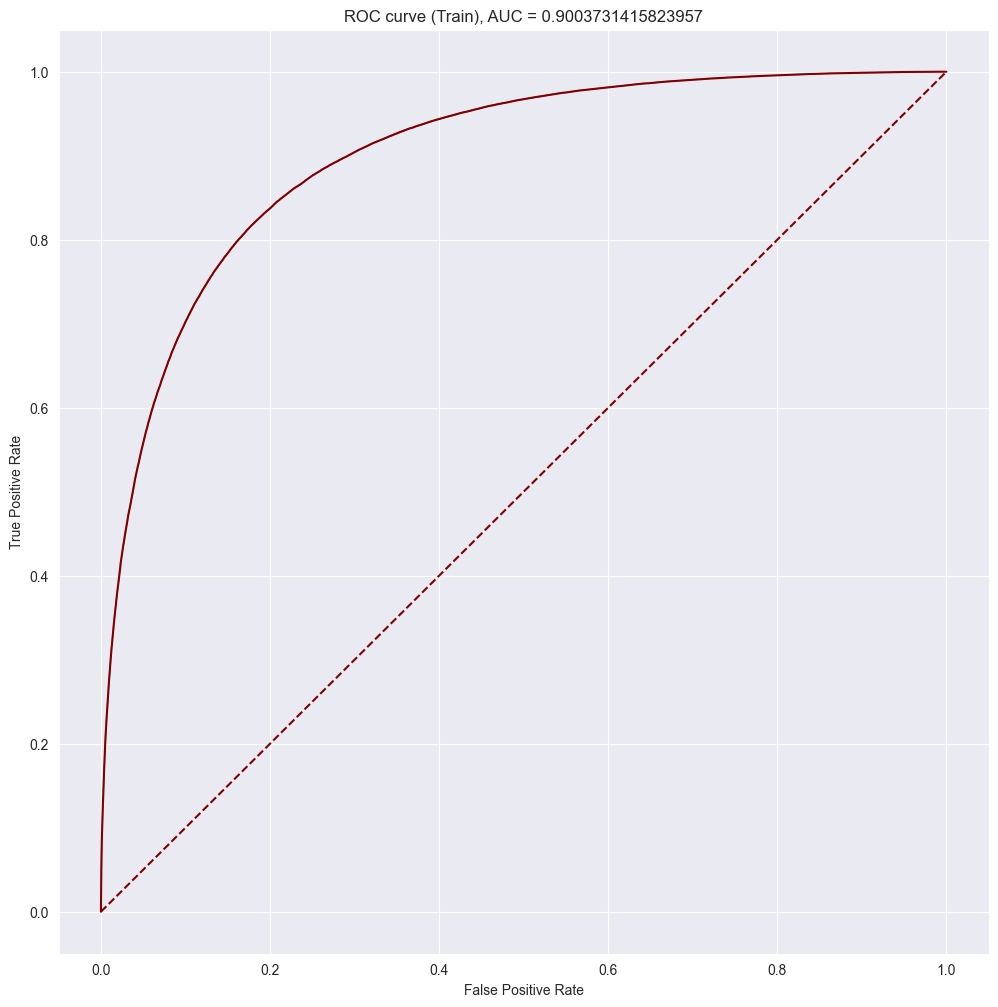

In [109]:
fig5, axes = plt.subplots(1, 1, figsize=(12, 12))
curve1_redone = sns.lineplot(x=fpr, y=tpr, color="maroon",ax=axes)
curve2_redone = sns.lineplot([0, 1], color='Maroon', linestyle='--',ax=axes)
axes.set_title('ROC curve (Train), AUC = '+repr(auc))
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")

### Calculating the Precision and Recall and F-Score

In [101]:
from sklearn.metrics import precision_recall_fscore_support
predictions = []
threshold = 0.8
for i in y_pred_proba[:,0]:
    if i>=threshold:
        predictions.append(1)
    else:
        predictions.append(0)
score = precision_recall_fscore_support(labels, predictions)

In [103]:
score

(array([0.69955341, 0.90842536]),
 array([0.93987937, 0.59636261]),
 array([0.80210159, 0.72003622]),
 array([159995, 160005], dtype=int64))

## Testing the Model, and making an End to End Model

In [43]:
test_df = pd.DataFrame({"text":["How to hang myslef"],"target":[1]})

In [44]:
test_df["text"] = test_df["text"].parallel_apply(stemmer_parallel)

In [45]:
new_test_ds = df_to_dataset(test_df)

In [46]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.predict(new_test_ds)

1/1 [==============================] - 0s 127ms/step


array([[0.51446253]], dtype=float32)

In [38]:
end_to_end_model.save('model_outputs/neural_net')

INFO:tensorflow:Assets written to: model_outputs/neural_net\assets


INFO:tensorflow:Assets written to: model_outputs/neural_net\assets
